# A deeper look at SVM architectures

In the last experiment that we ran, where we used a LinearSVM without changing any of the deafult parameters or feaure engineering, we achieved an accuracy of 63%. It also gave us convergence warnings for the linear kernel.
We expect that SVMs should be more capable than this, so in this notebook we will iterate over the SVM design and try different approaches to the problem using this classifier. The recommended SVM kernel for text classification is the linear kernel, so we will attempt to obtain a result from this.
Let's import what we need.

In [1]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import regplot
from scripts import training_helpers
from scripts.feature_extraction import get_balanced_dataset, get_entire_dataset, reviews_by_reviewer, reviewer_features, scaled_reviewer_features, unscaled_reviewer_features
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
import random

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC

In [3]:
all_reviews = get_balanced_dataset('../../data/yelpZip')

In [4]:
X = [x.review_content for x in all_reviews]
y = [1 if x.label else 0 for x in all_reviews]

In [5]:
train_X = X[:-10000]
train_y = y[:-10000]
test_X = X[-10000:]
test_y = y[-10000:]

In [6]:
train_reviews = all_reviews[:-10000]
test_reviews = all_reviews[-10000:]

## Start with Logistic Regression
Logistic Regression is simpler and faster than an SVM. It also correlates well with SVMs with a linear kernel. Both attempt to divide the samples. SVMs attempt to produce a wide margin in the division, and although logistic regression does not do this by design, it is known to produce results of this nature. Logistic regression is also a little easier to obtain metrics for, as we can also view the log loss metric. Because of all of this we will start with logistic regression to do our initial experimentation, and then switch to SVMs at the end when we are ready to change the penalty variable.

First are some helper functions to get the metrics:

In [7]:
from sklearn.metrics import roc_auc_score

def auroc_score_from_probabilities(probabilities, labels):
  true_probabilities = [probabilities[i][1] for i in range(0, len(labels))]
  return roc_auc_score(labels, true_probabilities)

In [8]:
import unittest

class TestRocScoreFromProbabilities(unittest.TestCase):
  
  def test_uses_correct_probabilities(self):
    probabilities = [[0.9, 0.1], [0.1, 0.9]]
    labels = [0, 1]
    self.assertEquals(1, auroc_score_from_probabilities(probabilities, labels))

unittest.main(argv=[''], verbosity=2, exit=False)

test_uses_correct_probabilities (__main__.TestRocScoreFromProbabilities) ... /home/skennedy/jupiter/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Please use assertEqual instead.
  
ok

----------------------------------------------------------------------
Ran 1 test in 0.023s

OK


We define a function to automate the process of cross validation and finding the accuracy, the mean, variance and our other metrics:

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, log_loss
import numpy as np
def run_cross_validate(model, X, y, get_features_fn, cv=5):
  skfSplitter = StratifiedKFold(n_splits=cv)
  metrics = {
    "accuracies": [],
    "auroc": [],
    "f1 scores": [],
    "log loss": []
  }
    
  false_negatives = 0
  false_positives = 0
  for train_indices, test_indices in skfSplitter.split(X, y):
    training_X = get_features_fn([X[x] for x in train_indices], fit=True)
    training_y = [y[x] for x in train_indices]
    test_X = get_features_fn([X[x] for x in test_indices])
    test_y = [y[x] for x in test_indices]
  
    model.fit(training_X, training_y)
    probabilities = model.predict_proba(test_X)
    
    predicted = [0 if x[0] > x[1] else 1 for x in probabilities]
    for i in range(0, len(predicted)):
      if (predicted[i] == 0 and test_y[i] == 1):
        false_negatives+=1
      if (predicted[i] == 1 and test_y[i] == 0):
        false_positives+=1
    
    metrics["accuracies"].append(accuracy_score(test_y, predicted))
    metrics["auroc"].append(auroc_score_from_probabilities(probabilities, test_y))
    metrics["f1 scores"].append(f1_score(test_y, predicted))
    metrics["log loss"].append(log_loss(test_y, probabilities))

  num_samples = len(X)
  metrics["mean accuracy"] = np.mean(metrics["accuracies"])
  metrics["mean variance"] = np.var(metrics["accuracies"])
  metrics["mean auroc"] = np.mean(metrics["auroc"])
  metrics["mean f1 scores"] = np.mean(metrics["f1 scores"])
  metrics["mean log loss"] = np.mean(metrics["log loss"])
  metrics["false negatives rate"] = (false_negatives / cv) / num_samples
  metrics["false positives rate"] = (false_positives / cv) / num_samples
  return metrics

In [10]:
classifier = LogisticRegression(solver="liblinear")

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
cVec = CountVectorizer()
def get_features(predictor_set, fit=False):
  if fit:
    return cVec.fit_transform(predictor_set)
  return cVec.transform(predictor_set)
run_cross_validate(classifier, train_X, train_y, get_features)

{'accuracies': [0.6575664621676892,
  0.6560092712523008,
  0.6542027404731066,
  0.6566228100074988,
  0.656554639034699],
 'auroc': [0.7090382377728721,
  0.7110041539261442,
  0.7050104944912053,
  0.7058718077125913,
  0.7063494808707668],
 'f1 scores': [0.6757672572369058,
  0.6746405313044039,
  0.671544662803121,
  0.6741914618369987,
  0.6746738990055534],
 'false negatives rate': 0.02885774275352439,
 'false positives rate': 0.039904016578954545,
 'log loss': [0.6646937968519574,
  0.6613014724303454,
  0.6679174158423338,
  0.6688356210562355,
  0.6664914798747142],
 'mean accuracy': 0.6561911845870588,
 'mean auroc': 0.707454834954716,
 'mean f1 scores': 0.6741635624373966,
 'mean log loss': 0.6658479572111173,
 'mean variance': 1.2393581037076362e-06}

## Metrics to evaluate

### Accuracy
This is the percentage of correct classifications. The higher the better, however it is not appropriate in all cases.

This metric falls to the imbalanced classification problem. When there are many more of one class, the classifier can choose it much more, or all the time, to achieve a high accuracy.

### False Positives, False Negatives
False positives are samples that were classified as fake, but were in fact genuine. False negatives are samples that were classified as genuine, but were in fact fake. We want to reduce both of these values as much as possible. True positives and true negatives are the adverse values which we want to maximise, although they correlate to false positives and negatives so there's no need to include them here.

One important question here is **False negatives vs False positives**? Is it worse to falsely suggest that something is fake, or is it worse to falsely suggest that something is genuine? Probably in this system a human might be paid to read those suspicious reviews. It would be good to catch all the fake reviews, plus some genuine ones, because this is just like filtering the huge number of reviews to make a human's job easier. In this case it is better to reduce false negatives. If humans are not reviewing the system, then this would be a different situation, it would probably be better to reduce false positives.

### Recall
Of all the fake reviews, what percentage were identified as fake? This is not subject to the imbalanced
classification problem. We aim to maximise it as an indication of how well we are really identifying our fake reviews. 

We cannot focus solely on recall, because we could identify all reviews as fake and achieve 100% recall. Precision must be included in the consideration.

### Precision
Of all the reviews identified as fake, what percentage are actually fake? If we classify all reviews as fake, then our precision will be low. If we classify all reviews as genuine, then we wont have any precision either.

In our case it might be more important to have a high recall, if we don't want to miss any fake reviews. Otherwise if we want to be as accurate as possible we can balance recall and precision.

### F1 Score
This is a harmonic mean of precision and recall. Because of this it punishes extreme values such as a recall of or a precision of 0.0

This also acts as a single number metric representing precision and recall.

### Area Under Curve (AUC) 
This gives us a measure of discrimination, how well we correctly classify both classes. This does not use a 'Yes' or 'No' which can make it more interesting than accuracy.

At different classification thresholds, how well do we predict fake reviews as 'more fake' than genuine reviews. We plot the true positive rate against the false positive rate to get a graph. Changing the threshold allows us to create a graph because at low thresholds we will have more fake reviews, increasing the true positives rate. Decreasing the treshold means we will have less genuine reviews, decreasing the true negative rate, which therefore increases the false positive rate.

An AUC of 0.8 means the chance of the model distinguishing positive and negative classes is 80%.

### Mean Squared Error
The average of the square difference between the original values and the predicted values. Adds focus to large errors, and is easier to compute than mean absolute error.

The closer the mean squared error is to zero the better. It incorporates the variance and the bias of the estimator

### Logarithmic loss
This takes into account the uncertainty of a prediction, taking into account how far away from the actual label the prediction is. As the probability approaches correct the log loss reduces only very little. As the probability approaches incorrect the log loss increases rapidly. This means that confident incorrect values are highly penalized.

We aim to minimize log loss.

### Cohen's Kappa
A reliability metric used when there is more than one classifier. Computes an agreement percentage of the used classifiers. It is out of scope at this stage.

## Current Results

Our results show quite normal results. The AUROC score and F1 score above are as expected, reflective of similar work in this field. We can see that the variance is not very large, so we can depend on our scores.

Since there is nothing alarming, the next thing to consider is improving features or trying to find more predictive features. We might see better results if convert our bow to tfidf. This is especially important because the normalisation function of logistic regression uses regularisation that depends on the features being scaled. Tfidf will scale our features for us.

In [12]:
def tf_idf_bag_of_words(cv, tfidf, predictor_set, fit):
  if fit:
    return tfidf.fit_transform(cv.fit_transform(predictor_set))
  else:
    return tfidf.transform(cv.transform(predictor_set))

In [13]:
count_vectorizer = CountVectorizer()
tfidf_transformer = TfidfTransformer()
def get_features(predictor_features, fit=False):
  return tf_idf_bag_of_words(count_vectorizer, tfidf_transformer, predictor_features, fit)

run_cross_validate(classifier, train_X, train_y, get_features)

{'accuracies': [0.6766530334014996,
  0.6761878792010362,
  0.6759151953098371,
  0.6733587838298453,
  0.673120185425046],
 'auroc': [0.7411217437620923,
  0.7407604142326529,
  0.7369276872766168,
  0.7374098148541618,
  0.7360339569427505],
 'f1 scores': [0.6783958778263671,
  0.6789889842535649,
  0.6762021522953275,
  0.6755594677861665,
  0.6750914758097303],
 'false negatives rate': 0.031930848308019524,
 'false positives rate': 0.03305974422599733,
 'log loss': [0.5985783624246397,
  0.5991454225306362,
  0.602045962686789,
  0.6020791586333034,
  0.6029064807267549],
 'mean accuracy': 0.6750470154334528,
 'mean auroc': 0.7384507234136549,
 'mean f1 scores': 0.6768475915942312,
 'mean log loss': 0.6009510774004245,
 'mean variance': 2.2394799952697163e-06}

Looks like switching to Tfidf had a positive effect on our results, which is not unexpected. Let's have a look at our vocabulary, to see what words are actually in our bag of words. Let's try to clean our features more, hopefully a smaller number of features, more concentrated with quality words will improve accuracy. Currently our bag of words has the following shape: 

In [14]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(train_X).shape

(146692, 78571)

At this point I tried to improve features in a number of ways. I expected that stopwords are not just noise in this classification, unlike topic of sentiment classification. When I removed them it actually caused a drop in accuracy, so I kept them in. I also tried lemmatizing words, however this did not boost accuracy much, and for the time taken to do this I decided to just leave them out.

Let's set a low limit for the vocab size. This cleans out everything from the typos to the random jibberish:

In [15]:
count_vectorizer = CountVectorizer(max_features=10000)
count_vectorizer.fit_transform(train_X).shape

(146692, 10000)

In [16]:
run_cross_validate(classifier, train_X, train_y, get_features)

{'accuracies': [0.6767552828902522,
  0.675301656554639,
  0.6760174517690367,
  0.6725748176426478,
  0.6724043902106484],
 'auroc': [0.7407907328218801,
  0.7399411705275353,
  0.7359208421097245,
  0.7373292286683735,
  0.735448078804511],
 'f1 scores': [0.6788785806189476,
  0.6783278179239549,
  0.6767996191642014,
  0.6751876648407384,
  0.6743910288986008],
 'false negatives rate': 0.03188040247593598,
 'false positives rate': 0.033197447713576744,
 'log loss': [0.5987957763981921,
  0.5996890263397473,
  0.6027445645635513,
  0.6020283564427854,
  0.6032734237147689],
 'mean accuracy': 0.6746107198134449,
 'mean auroc': 0.7378860105864048,
 'mean f1 scores': 0.6767169422892886,
 'mean log loss': 0.601306229491809,
 'mean variance': 3.2136454261706143e-06}

Now let's try adding reviewer features. First we can visualize the separativity of these features individually:

In [17]:
entire_review_set = get_entire_dataset()

In [18]:
len(entire_review_set)

608598

In [25]:
n = 10000
reviews = all_reviews[:n]
reviewer_reviews = reviews_by_reviewer(entire_review_set)
reviewer_predictors = np.array([np.array(reviewer_features(x.user_id, reviewer_reviews)) for x in reviews])
plot_targets = pd.Series(train_y[:n], name="Probability of being deceptive")

reviewer_predictors

(array([[4.00000000e+00, 1.14533333e+03, 7.25476250e-01, 7.94871795e-01,
         2.56410256e-02],
        [1.00000000e+00, 3.34666667e+02, 5.77350269e-01, 1.00000000e+00,
         0.00000000e+00],
        [1.00000000e+00, 1.59000000e+02, 0.00000000e+00, 1.00000000e+00,
         0.00000000e+00],
        ...,
        [1.00000000e+00, 2.81000000e+02, 0.00000000e+00, 1.00000000e+00,
         0.00000000e+00],
        [1.00000000e+00, 3.82666667e+02, 1.52752523e+00, 6.66666667e-01,
         3.33333333e-01],
        [1.00000000e+00, 2.93000000e+02, 0.00000000e+00, 0.00000000e+00,
         1.00000000e+00]]),
 array([[ 1.40028677,  1.68485302,  0.37452905,  0.20979946, -0.44738045],
        [-0.5047789 , -0.49119012,  0.12885675,  0.7936202 , -0.52912084],
        [-0.5047789 , -0.96272578, -0.82869957,  0.7936202 , -0.52912084],
        ...,
        [-0.5047789 , -0.6352456 , -0.82869957,  0.7936202 , -0.52912084],
        [-0.5047789 , -0.36234546,  1.70475631, -0.15508849,  0.53350414],
   

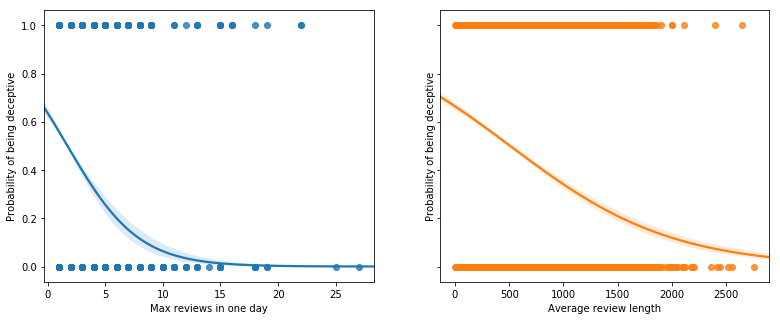

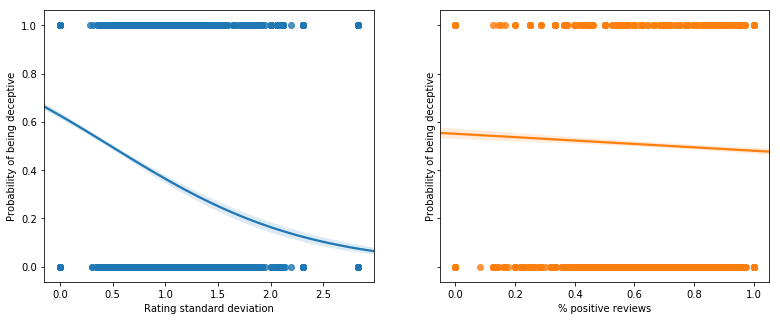

In [26]:
plt.rcParams['figure.figsize'] = [13, 5]

_, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
regplot(pd.Series(reviewer_predictors[:,0], name="Max reviews in one day"), plot_targets, logistic=True, ax=ax1)
regplot(pd.Series(reviewer_predictors[:,1], name="Average review length"), plot_targets, logistic=True, ax=ax2)

_, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
regplot(pd.Series(reviewer_predictors[:,2], name="Rating standard deviation"), plot_targets, logistic=True, ax=ax1)
regplot(pd.Series(reviewer_predictors[:,3], name="% positive reviews"), plot_targets, logistic=True, ax=ax2)

It seems that the most separable features are max reviews in one day, where more reviews in a day becomes a very strong indicator of fake reviews, and average length of review, where longer reviews are much more likely to be genuine.

The standard deviation of a user's rating is also informative, where highly varying ratings from a user tend to be an indication that the user's reviews are genuine.

The percentage of positive and negative reviews only provides a slight indication of deceptiveness. In this case having almost entirely negative reviews is slightly indicative of deception.

And now training a model with these:

In [27]:
from exp2_feature_extraction import reviewer_features, reviews_by_reviewer
from scipy.sparse import coo_matrix, hstack

count_vectorizer = CountVectorizer(max_features=10000)
tfidf_transformer = TfidfTransformer()
def get_features(predictor_features, fit=False):
  predictor_features_text = [x.review_content for x in predictor_features]
  bow = tf_idf_bag_of_words(count_vectorizer, tfidf_transformer, predictor_features_text, fit)
  reviewer_scaled = scaled_reviewer_features(predictor_features, entire_review_set)
  return hstack([coo_matrix(reviewer_scaled), bow])

run_cross_validate(LogisticRegression(solver="liblinear"), train_reviews, train_y, get_features)

{'accuracies': [0.7159509202453987,
  0.7118412979753221,
  0.712795691594519,
  0.715318017588111,
  0.7091826300361306],
 'auroc': [0.7840512510590931,
  0.7826591382564404,
  0.7830756043929079,
  0.7833506653698893,
  0.7827139599132928],
 'f1 scores': [0.7167810779582683,
  0.7119787408013082,
  0.7130499931889388,
  0.716670059027071,
  0.7086662569145668],
 'false negatives rate': 0.028545523954953234,
 'false positives rate': 0.028850925749188776,
 'log loss': [0.5618835040658553,
  0.5624472488500832,
  0.5622034566550291,
  0.5629638210189147,
  0.5621229403660819],
 'mean accuracy': 0.7130177114878963,
 'mean auroc': 0.7831701237983248,
 'mean f1 scores': 0.7134292255780306,
 'mean log loss': 0.562324194191193,
 'mean variance': 6.007242619414739e-06}

I also tried adding a number of other features derived from these, but it seems that only the raw features would give me an increase in performance. These include sentiment, POS tags and structural features. Now let's try adding bigrams, which are known to help with improving accuracy:

In [28]:
from exp2_feature_extraction import sentiment_features, find_words
from nltk.sentiment.vader import SentimentIntensityAnalyzer

count_vectorizer.set_params(ngram_range=(1,2))
run_cross_validate(LogisticRegression(solver="liblinear"), train_reviews, train_y, get_features)

{'accuracies': [0.7133946830265848,
  0.7087395187129321,
  0.714977162724112,
  0.7126934351353194,
  0.7104778785193264],
 'auroc': [0.7834069422008427,
  0.7802640362309505,
  0.7838150844810724,
  0.7812995830087207,
  0.7822693289269669],
 'f1 scores': [0.7147267360993318,
  0.7091459886313353,
  0.7155975783960276,
  0.7143583313565353,
  0.7110687801891286],
 'false negatives rate': 0.028465083303792982,
 'false positives rate': 0.029123605922613365,
 'log loss': [0.562407241988577,
  0.5647741234411455,
  0.561373928808294,
  0.5649816229446597,
  0.5622027655982407],
 'mean accuracy': 0.712056535623655,
 'mean auroc': 0.7822109949697106,
 'mean f1 scores': 0.7129794829344717,
 'mean log loss': 0.5631479365561833,
 'mean variance': 4.844220311783859e-06}

In [29]:
model = LogisticRegression(solver="liblinear")
model.fit(get_features(train_reviews, fit=True), train_y)
scores = model.predict_proba(get_features(test_reviews))

In [30]:
scores

array([[0.58851075, 0.41148925],
       [0.70615049, 0.29384951],
       [0.14027339, 0.85972661],
       ...,
       [0.10930956, 0.89069044],
       [0.94278397, 0.05721603],
       [0.96619625, 0.03380375]])

In [31]:
model = LogisticRegression(solver="liblinear")

In [32]:
from sklearn.decomposition import PCA
x_features = get_features(train_reviews, fit=True).todense()

pca = PCA(n_components=2).fit(x_features)
data2D = pca.transform(x_features)
model.fit(data2D, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
test2D = pca.transform(get_features(test_reviews).todense())

In [34]:
model.score(test2D, test_y)

0.6871

In [35]:
x_min, x_max = data2D[:, 0].min() - 1, data2D[:, 0].max() + 1
y_min, y_max = data2D[:, 1].min() - 1, data2D[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01), np.arange(y_min, y_max, .01))

Z = model.predict(np.c_[xx.ravel(),  yy.ravel()])
Z = Z.reshape(xx.shape)

In [36]:
def subplot_classifications(subplot_number, title, colour, data, xx, yy, Z, label,
                            indices=None, rows=2):
    if indices == None:
        indices = random.sample(range(0, data2D.shape[0]), 5000)
    plt.subplot(rows, 2, subplot_number)

    plt.contourf(xx, yy, Z, colors=['#a3ffa9', '#ffa3a3', 'black'], extend="both")
    for i in indices:
        if train_y[i] == label:
            plt.scatter(data[i,0], data[i,1], c=colour, marker='+')
    plt.contour(xx, yy, Z)
    plt.title(title)
    plt.axis('on')    

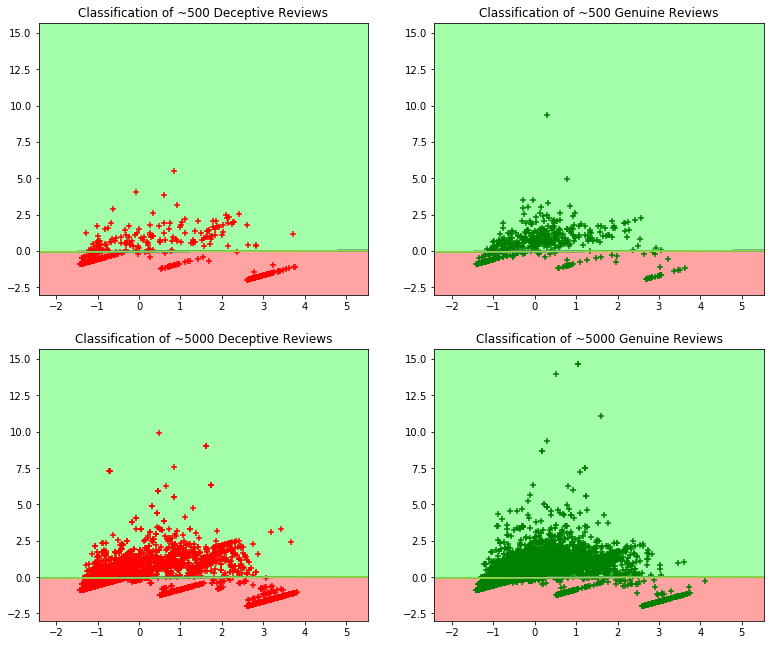

In [37]:
plt.rcParams['figure.figsize'] = [13, 11]
indices1000 = random.sample(range(0, data2D.shape[0]), 1000)
subplot_classifications(1, "Classification of ~500 Deceptive Reviews", "r", data2D, xx, yy, Z, label=1, indices=indices1000)
subplot_classifications(2, "Classification of ~500 Genuine Reviews", "g", data2D, xx, yy, Z, label=0, indices=indices1000)
indices10000 = random.sample(range(0, data2D.shape[0]), 10000)
subplot_classifications(3, "Classification of ~5000 Deceptive Reviews", "r", data2D, xx, yy, Z, label=1, indices=indices10000)
subplot_classifications(4, "Classification of ~5000 Genuine Reviews", "g", data2D, xx, yy, Z, label=0, indices=indices10000)
plt.show()

The green marks represent genuine reviews, and the red marks represent deceptive reviews. 

Logisitc regression finds the above division in the data samples. Although logistic regression does not create a linear separation, it does create a linear separation in the maximum likelihood and in this case it creates a straight line division of the samples.

Adding bigrams gives us a tiny boost, and now we're closing in on a good statistical benchmark. Let's switch to SVC as we should have more tweakable options. We have to drop some of our metrics based on probabilities because the underlying implementation of LinearSVC does not expose them to us. We will disable dual because our number of samples exceeds our number of features:

In [39]:
def run_cross_validate(model, X, y, get_features_fn, cv=5):
  skfSplitter = StratifiedKFold(n_splits=cv)
  metrics = { "accuracies": [], "auroc": [], "f1 scores": [] }
    
  for train_indices, test_indices in skfSplitter.split(X, y):
    training_X = get_features_fn([X[x] for x in train_indices], fit=True)
    training_y = [y[x] for x in train_indices]
    test_X = get_features_fn([X[x] for x in test_indices])
    test_y = [y[x] for x in test_indices]
  
    model.fit(training_X, training_y)
    scores = model.decision_function(test_X)
    
    predicted = [1 if score >= 0 else 0 for score in scores]
    metrics["accuracies"].append(accuracy_score(test_y, predicted))
    metrics["auroc"].append(roc_auc_score(test_y, scores))
    metrics["f1 scores"].append(f1_score(test_y, predicted))

  num_samples = len(X)
  metrics["mean accuracy"] = np.mean(metrics["accuracies"])
  metrics["mean variance"] = np.var(metrics["accuracies"])
  metrics["mean auroc"] = np.mean(metrics["auroc"])
  metrics["mean f1 scores"] = np.mean(metrics["f1 scores"])
  return metrics

In [40]:
run_cross_validate(LinearSVC(max_iter=2500, dual=False), train_reviews, train_y, get_features)

{'accuracies': [0.7035105657805044,
  0.7012066262185561,
  0.7024337037289522,
  0.7017860794873543,
  0.7017519940009544],
 'auroc': [0.771244252775997,
  0.7693593527191895,
  0.7696866932900133,
  0.7693547217031209,
  0.7682742055053927],
 'f1 scores': [0.7045477702679754,
  0.7017555797495918,
  0.7038670284938943,
  0.7035342753549524,
  0.702056660310542],
 'mean accuracy': 0.7021377938432642,
 'mean auroc': 0.7695838451987427,
 'mean f1 scores': 0.7031522628353912,
 'mean variance': 6.223366207811985e-07}

It looks like the accuracy is pretty similar, but a little lower. Now let's try automatic tuning of hyperparameters. Since this will be tuning our parameters towards a set, we will use a dev set for this, and have a test set to check how the tuned model works on totally unseen data. A major parameter to grid search on is C, the penalty parameter of the error term.

In [21]:
from sklearn.model_selection import GridSearchCV

train_dev_set = all_reviews[:-5000]
train_dev_y = y[:-5000]

test_set = all_reviews[-5000:]
test_set_y = y[-5000:]

model = LinearSVC(max_iter=2500, dual=False)

grid_search = GridSearchCV(cv=5, estimator=model, param_grid={"C": [0.01, 0.025, 0.05, 0.075, 0.1, 0.3, 0.7, 1.0, 10.0]})
grid_search.fit(get_features(train_dev_set), train_dev_y).best_params_

{'C': 0.025}

Grid search has now found a 'best' value for C. Now let's try this value with our SVM to see how it performs:

In [22]:
from sklearn.model_selection import cross_validate
cross_validate(LinearSVC(max_iter=2500, dual=False, C=0.025), get_features(train_dev_set), train_dev_y, cv=10)

/home/stefan/anaconda3/envs/lucas/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/stefan/anaconda3/envs/lucas/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([10.10894036, 12.58361363, 11.71966481, 13.25194311, 13.75658846,
        11.85658526, 11.91894174, 11.76314402, 12.6587317 , 12.27675748]),
 'score_time': array([0.01081014, 0.01152873, 0.01058412, 0.01410556, 0.01031327,
        0.01303434, 0.00918007, 0.01168156, 0.01051784, 0.01208258]),
 'test_score': array([0.73857162, 0.75029813, 0.74135418, 0.74347423, 0.74464984,
        0.74783012, 0.74007818, 0.74836017, 0.74286093, 0.74973496]),
 'train_score': array([0.75967874, 0.75869228, 0.75879534, 0.75923704, 0.75892226,
        0.75897379, 0.75981302, 0.7586278 , 0.75936396, 0.75885042])}

Impressive, this is our best validation accuracy yet! Now let's run it on an unseen section of data, something that has been neglected for far too long at this stage:

In [23]:
model = LinearSVC(max_iter=2500, dual=False, C=0.025)
model.fit(get_features(train_dev_set), train_dev_y)
model.score(get_features(test_set), test_set_y)

0.7236

In [32]:
pca = PCA(n_components=2).fit(x_features)
data2D = pca.transform(x_features)

In [33]:
linearSVC = LinearSVC(max_iter=2500, dual=False, C=0.05)
linearSVC.fit(data2D, train_dev_y)

LinearSVC(C=0.05, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2500,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [34]:
linearSVC.score(test2D, test_y)

0.603

In [35]:
x_min, x_max = data2D[:, 0].min() - 1, data2D[:, 0].max() + 1
y_min, y_max = data2D[:, 1].min() - 1, data2D[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01), np.arange(y_min, y_max, .01))

Z = model.predict(np.c_[xx.ravel(),  yy.ravel()])
Z = Z.reshape(xx.shape)

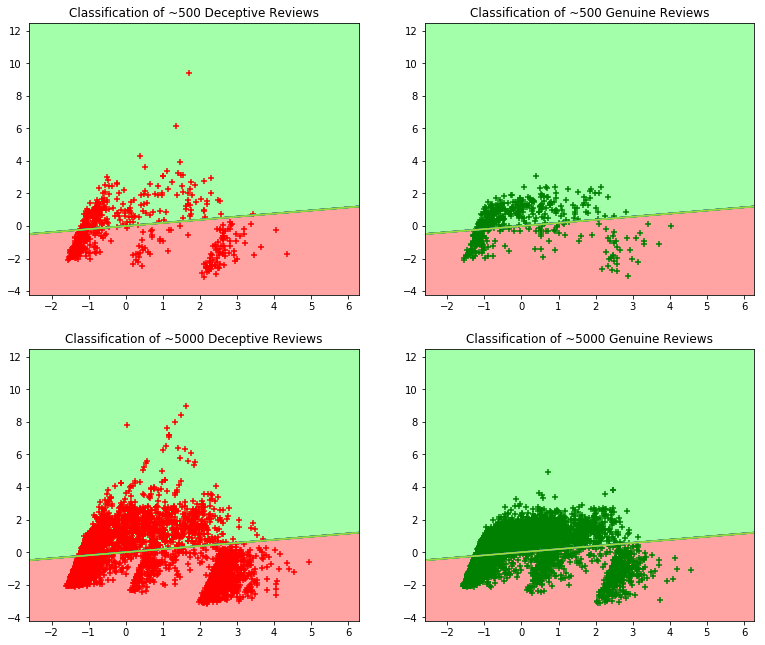

In [36]:
subplot_classifications(1, "Classification of ~500 Deceptive Reviews", "r", data2D, xx, yy, Z, label=1, indices=indices1000)
subplot_classifications(2, "Classification of ~500 Genuine Reviews", "g", data2D, xx, yy, Z, label=0, indices=indices1000)
subplot_classifications(3, "Classification of ~5000 Deceptive Reviews", "r", data2D, xx, yy, Z, label=1, indices=indices10000)
subplot_classifications(4, "Classification of ~5000 Genuine Reviews", "g", data2D, xx, yy, Z, label=0, indices=indices10000)
plt.show()

At this dimensionality, our graphs are making identical classifications for Logistic Regression and SVM with a linear core. This means the improved accuracy when moving from Logistic Regression to SVM depends on the number of features, and it is explainable that this difference can occur because Logistic Regression makes simplifying assumptions.

It can be seen that when reduced to these two dimensions a linear divide will only be capable of classifying these samples to some maximal accuracy. This is to an extent representative of the real layout of the data.

In [77]:
model.fit(get_features(train_dev_X, fit=True), train_dev_y)
scores = model.decision_function(get_features(test_X))

In [83]:
predicted = [1 if score >= 0 else 0 for score in scores]
print("Classification Accuracy:", accuracy_score(test_y, predicted))
print("AUROC:", roc_auc_score(test_y, scores))
print("F1 Score:", f1_score(test_y, predicted))

Classification Accuracy: 0.7175
AUROC: 0.791287949154769
F1 Score: 0.7197698641007837


In [153]:
nuSVM = NuSVC()

In [ ]:
nuSVM.fit(get_features(train_dev_X, fit=True), train_dev_y)

/home/skennedy/jupiter/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [157]:
scores = nuSVM.decision_function(get_features(test_X))

In [158]:
scores

array([-0.51243558, -4.4315774 , -1.70306441, ...,  2.77727383,
        0.11818758, -1.70486489])

In [159]:
predicted = [1 if score >= 0 else 0 for score in scores]
print("Classification Accuracy:", accuracy_score(test_y, predicted))
print("AUROC:", roc_auc_score(test_y, scores))
print("F1 Score:", f1_score(test_y, predicted))

Classification Accuracy: 0.6734
AUROC: 0.7382471534273405
F1 Score: 0.6871048093504504


In [ ]:
grid_search = GridSearchCV(cv=3, estimator=nuSVM, param_grid={"nu": [0.1, 0.3, 0.51, 0.7, 0.9, 1.0]})
nuSVM_best_params = grid_search.fit(get_features(train_dev_X), train_dev_y).best_params_

/home/skennedy/jupiter/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
nuSVM = NuSVC()

x_features = get_features(train_dev_X, fit=True).todense()

pca = PCA(n_components=2).fit(x_features)
data2D = pca.transform(x_features)

nuSVM.fit(data2D, train_dev_y)

/home/skennedy/jupiter/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
x_min, x_max = data2D[:, 0].min() - 1, data2D[:, 0].max() + 1
y_min, y_max = data2D[:, 1].min() - 1, data2D[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .01), np.arange(y_min, y_max, .01))

Z = nuSVM.predict(np.c_[xx.ravel(),  yy.ravel()])
Z = Z.reshape(xx.shape)

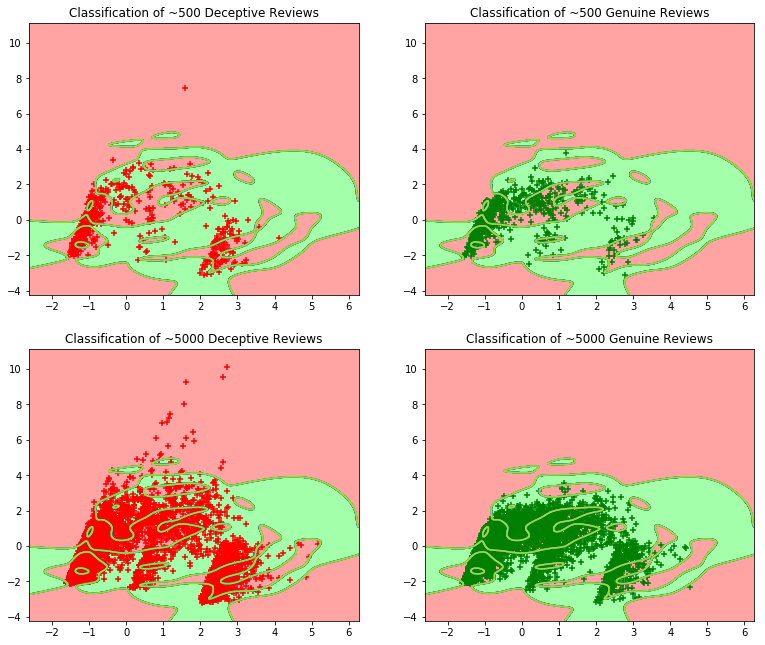

In [36]:
subplot_classifications(1, "Classification of ~500 Deceptive Reviews", "r", data2D, xx, yy, Z, label=1, indices=indices1000)
subplot_classifications(2, "Classification of ~500 Genuine Reviews", "g", data2D, xx, yy, Z, label=0, indices=indices1000)
subplot_classifications(3, "Classification of ~5000 Deceptive Reviews", "r", data2D, xx, yy, Z, label=1, indices=indices10000)
subplot_classifications(4, "Classification of ~5000 Genuine Reviews", "g", data2D, xx, yy, Z, label=0, indices=indices10000)

An SVM without a linear kernel appears much more capable of dividing reviews, however in practice it does not outperform the linear kernel. This is not displayed by the above visualisations, but is explainable because we are only viewing 2 components calculated by the PCA algorithm. The linear hyperplane must find a better separation in the high dimensionality space.